install and import libraries

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

print("TensorFlow version:", tf.__version__)
print("All libraries loaded ✅")

TensorFlow version: 2.19.0
All libraries loaded ✅


Reading data from csv

In [57]:
df = pd.read_csv("poses.csv")

feature_cols = [c for c in df.columns if c not in ["frame_id", "sequence_id", "label"]]

print("Dataset shape:", df.shape)
print("\nSamples per pose:")
print(df["label"].value_counts())
df.head()

Dataset shape: (4145, 102)

Samples per pose:
label
TreePose       806
DownwardDog    715
CobraPose      705
GoddessPose    662
ChairPose      636
WarriorPose    621
Name: count, dtype: int64


,frame_id,sequence_id,label,x0,y0,z0,x1,y1,z1,x2,...,z29,x30,y30,z30,x31,y31,z31,x32,y32,z32
0,0,0,TreePose,0.419386,0.248265,-0.275400,0.424242,0.236591,-0.249677,0.427660,...,0.195322,0.442232,0.910655,0.081239,0.403641,0.671678,0.159295,0.416467,0.940701,-0.031911
1,1,0,TreePose,0.419377,0.248428,-0.279180,0.424232,0.236687,-0.253595,0.427652,...,0.191805,0.441200,0.910158,0.078871,0.403643,0.669698,0.156432,0.416787,0.938885,-0.032200
2,2,0,TreePose,0.419373,0.248785,-0.280944,0.424204,0.236893,-0.255115,0.427622,...,0.213162,0.440979,0.912148,0.086075,0.404011,0.672451,0.174355,0.416278,0.941927,-0.032549
3,3,0,TreePose,0.419459,0.248527,-0.270080,0.424211,0.236746,-0.244286,0.427625,...,0.210307,0.441482,0.916521,0.089484,0.403871,0.672470,0.171566,0.413831,0.941901,-0.026237
4,4,0,TreePose,0.418023,0.247794,-0.272022,0.423072,0.236481,-0.245601,0.426543,...,0.235778,0.441495,0.916220,0.110470,0.404689,0.671030,0.202445,0.413887,0.942929,-0.004609


In [58]:
def inject_random_samples(df, feature_cols, n_samples=200):
    random_rows = []

    for _ in range(n_samples):
        fake_landmarks = np.random.uniform(0, 1, len(feature_cols))
        fake_label = np.random.choice(df["label"].unique())

        row = {
            "frame_id": -1,
            "sequence_id": -1,
            "label": fake_label
        }

        for col, val in zip(feature_cols, fake_landmarks):
            row[col] = val

        random_rows.append(row)

    df_random = pd.DataFrame(random_rows)
    df_combined = pd.concat([df, df_random], ignore_index=True)

    return df_combined

# Inject
df = inject_random_samples(df, feature_cols, n_samples=300)


Visualise the Data

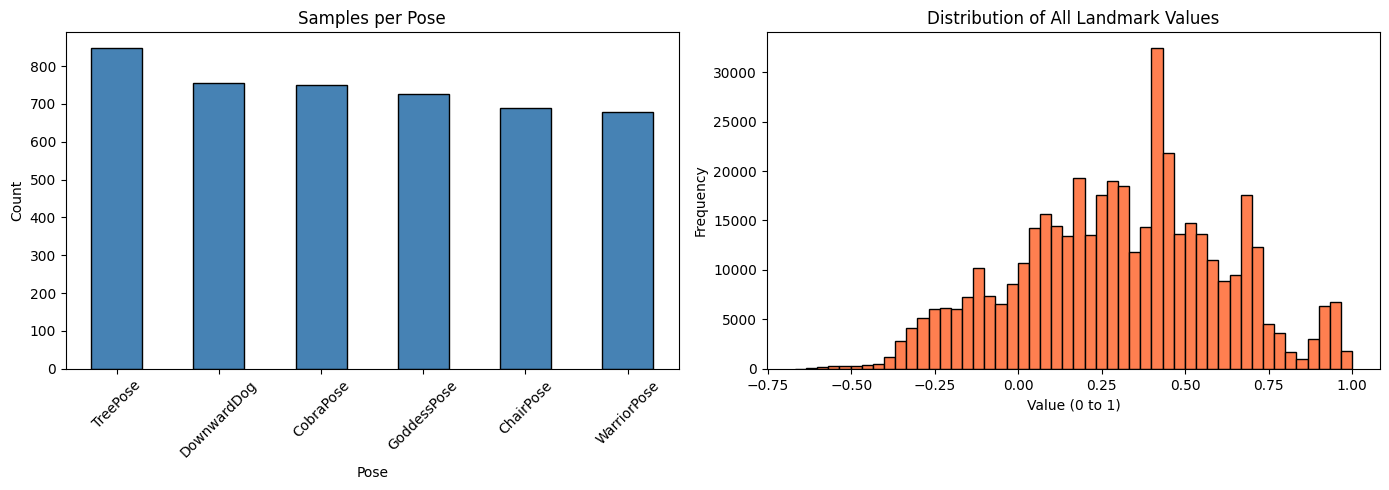

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Chart 1: How many samples per pose ---
df["label"].value_counts().plot(kind="bar", ax=axes[0], color="steelblue", edgecolor="black")
axes[0].set_title("Samples per Pose")
axes[0].set_xlabel("Pose")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

# --- Chart 2: Landmark value distribution ---
axes[1].hist(df[feature_cols].values.flatten(), bins=50, color="coral", edgecolor="black")
axes[1].set_title("Distribution of All Landmark Values")
axes[1].set_xlabel("Value (0 to 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Encode Labels & Split Data

In [60]:
# Step 1: Convert text labels → numbers
le = LabelEncoder()
y = le.fit_transform(df["label"])

print("Label encoding:")
for i, name in enumerate(le.classes_):
    print(f"  {i} → {name}")

# Step 2: Convert numbers → one-hot vectors
y_onehot = to_categorical(y)
print("\nExample one-hot (first row):", y_onehot[0])

# Step 3: Get features
X = df[feature_cols].values

# Step 4: Split into train and test
# Get unique sequence IDs and split THOSE
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df["sequence_id"]))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y_onehot[train_idx], y_onehot[test_idx]

print(f"\nTraining samples : {len(X_train)}")
print(f"Testing samples  : {len(X_test)}")

Label encoding:
  0 → ChairPose
  1 → CobraPose
  2 → DownwardDog
  3 → GoddessPose
  4 → TreePose
  5 → WarriorPose

Example one-hot (first row): [0. 0. 0. 0. 1. 0.]

Training samples : 3698
Testing samples  : 747


Build the Model

In [61]:
model = Sequential([
    Dense(128, activation="relu", input_shape=(99,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(6, activation="softmax")
], name="PoseClassifier")

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "PoseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,214 (86.77 KB)

 Trainable params: 21,830 (85.27 KB)

 Non-trainable params: 384 (1.50 KB)

Compile & Train the Model

In [62]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6862 - loss: 1.0269 - val_accuracy: 0.8849 - val_loss: 0.8157
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9219 - loss: 0.3064 - val_accuracy: 1.0000 - val_loss: 0.2255
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9353 - loss: 0.2064 - val_accuracy: 1.0000 - val_loss: 0.0746
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9369 - loss: 0.2107 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.1891 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.1898 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9340 - loss: 0.1964 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9304 - loss: 0.2019 - val_accuracy: 1.

Visualise Training Curves

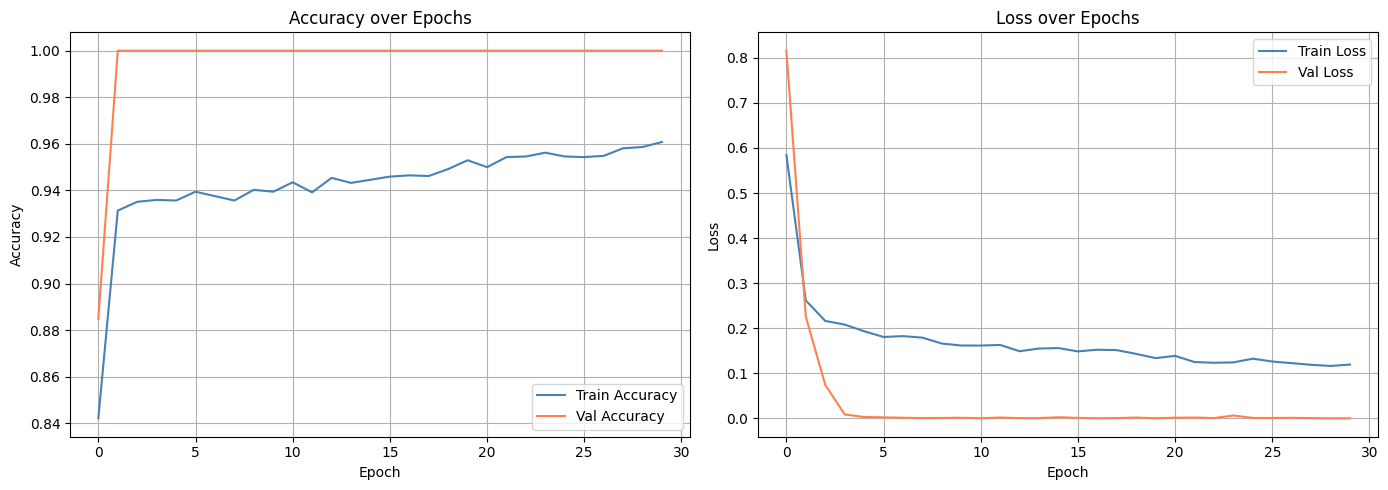

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Chart 1: Accuracy ---
axes[0].plot(history.history["accuracy"], label="Train Accuracy", color="steelblue")
axes[0].plot(history.history["val_accuracy"], label="Val Accuracy", color="coral")
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# --- Chart 2: Loss ---
axes[1].plot(history.history["loss"], label="Train Loss", color="steelblue")
axes[1].plot(history.history["val_loss"], label="Val Loss", color="coral")
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

 Confusion Matrix

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


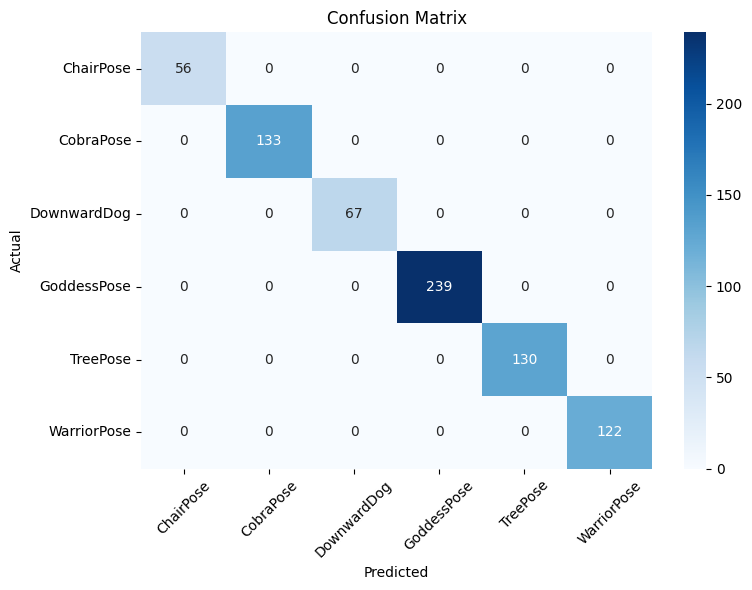

In [64]:
# Get predictions on test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # highest probability = predicted class
y_true = np.argmax(y_test, axis=1)        # actual class

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Print All the Metrics

In [65]:
print("=" * 50)
print("FINAL MODEL EVALUATION")
print("=" * 50)

# Overall accuracy
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nOverall Accuracy : {accuracy*100:.2f}%")
print(f"Overall Loss     : {loss:.4f}")

# Top-1 and Top-2 accuracy
top1 = tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred_probs, k=1).numpy().mean()
top2 = tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred_probs, k=2).numpy().mean()
print(f"\nTop-1 Accuracy   : {top1*100:.2f}%  (is correct pose the #1 prediction?)")
print(f"Top-2 Accuracy   : {top2*100:.2f}%  (is correct pose in top 2 predictions?)")

# Per-pose breakdown
print("\n" + "=" * 50)
print("PER POSE BREAKDOWN")
print("=" * 50)
print(classification_report(
    y_true,
    y_pred,
    labels=range(len(le.classes_)),
    target_names=le.classes_,
    zero_division=0
))

FINAL MODEL EVALUATION

Overall Accuracy : 100.00%
Overall Loss     : 0.0004

Top-1 Accuracy   : 100.00%  (is correct pose the #1 prediction?)
Top-2 Accuracy   : 100.00%  (is correct pose in top 2 predictions?)

PER POSE BREAKDOWN
              precision    recall  f1-score   support

   ChairPose       1.00      1.00      1.00        56
   CobraPose       1.00      1.00      1.00       133
 DownwardDog       1.00      1.00      1.00        67
 GoddessPose       1.00      1.00      1.00       239
    TreePose       1.00      1.00      1.00       130
 WarriorPose       1.00      1.00      1.00       122

    accuracy                           1.00       747
   macro avg       1.00      1.00      1.00       747
weighted avg       1.00      1.00      1.00       747



Save the Model

In [66]:
import os
import pickle

os.makedirs("models", exist_ok=True)

# Save the model
model.save("models/pose_classifier.h5")

# Save the label encoder (needed to convert numbers back to pose names later)
with open("models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("Model saved    → models/pose_classifier.h5")
print("Encoder saved  → models/label_encoder.pkl")

Model saved    → models/pose_classifier.h5
Encoder saved  → models/label_encoder.pkl


Test the Model

In [67]:
CONFIDENCE_THRESHOLD = 0.6

def predict_pose(landmarks):
    x = np.array(landmarks).reshape(1, -1)
    probs = model.predict(x, verbose=0)[0]

    top_idx = np.argmax(probs)
    confidence = probs[top_idx]
    label = le.inverse_transform([top_idx])[0]

    if confidence < CONFIDENCE_THRESHOLD:
        return "Unknown Pose", confidence
    return label, confidence

# Simulate a single frame coming from webcam
fake_frame = np.random.uniform(0, 1, 99)
label, confidence = predict_pose(fake_frame)

print(f"Predicted Pose : {label}")
print(f"Confidence     : {confidence*100:.2f}%")

# Show all pose probabilities
probs = model.predict(fake_frame.reshape(1, -1), verbose=0)[0]
print("\nAll probabilities:")
for name, prob in zip(le.classes_, probs):
    bar = "█" * int(prob * 40)
    print(f"  {name:<15} {prob*100:5.1f}%  {bar}")

Predicted Pose : GoddessPose
Confidence     : 87.15%

All probabilities:
  ChairPose         4.5%  █
  CobraPose         5.5%  ██
  DownwardDog       2.2%  
  GoddessPose      87.2%  ██████████████████████████████████
  TreePose          0.6%  
  WarriorPose       0.1%  


In [68]:
print("Unique train sequences:", len(set(df.iloc[train_idx]["sequence_id"])))
print("Unique test sequences :", len(set(df.iloc[test_idx]["sequence_id"])))


Unique train sequences: 36
Unique test sequences : 9


In [69]:
train_seqs = set(df.iloc[train_idx]["sequence_id"])
test_seqs  = set(df.iloc[test_idx]["sequence_id"])

print("Overlap:", train_seqs.intersection(test_seqs))


Overlap: set()
